In [75]:
!pip install opencv-python-headless pytesseract easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 19.7 MB/s eta 0:00:00


# **Import Modules**

In [77]:
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import pytesseract
import easyocr

from PIL import Image
from scipy.spatial import distance
from scipy.signal import wiener

# **Dataset**

In [3]:
path = kagglehub.dataset_download("andrewmvd/car-plate-detection")

100%|██████████| 203M/203M [00:09<00:00, 21.8MB/s]

Extracting files...


In [4]:
images = []
annotations = []

for root, dirs, files in os.walk(path):
    for file in files:
      if file.endswith(".png"):
        images.append(os.path.join(root, file))
      elif file.endswith(".xml"):
        annotations.append(os.path.join(root, file))

In [5]:
images_annot = []

for image in images:
  for annotation in annotations:
    if image.split('/')[-1].split('.')[0] == annotation.split('/')[-1].split('.')[0]:
      images_annot.append((image, annotation))

# **Data Overview**

In [9]:
tree = ET.parse(images_annot[1][1])
root = tree.getroot()

In [10]:
def print_all_elements(element, indent=0):
    for child in element:
        print("  " * indent + f"{child.tag}: {child.text.strip() if child.text else ''}")
        print_all_elements(child, indent + 1)

print_all_elements(root)

folder: images
filename: Cars294.png
size: 
  width: 400
  height: 267
  depth: 3
segmented: 0
object: 
  name: licence
  pose: Unspecified
  truncated: 0
  occluded: 0
  difficult: 0
  bndbox: 
    xmin: 142
    ymin: 117
    xmax: 218
    ymax: 135


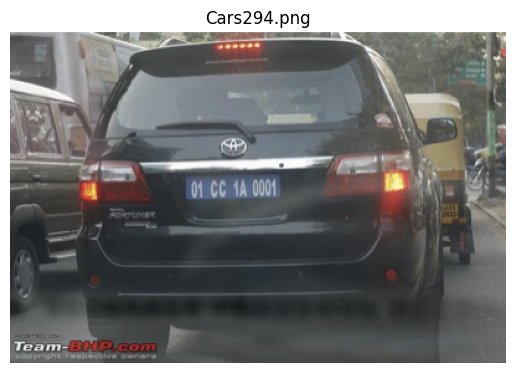

In [11]:
image = mpimg.imread(images_annot[1][0])
xmin, ymin = 274, 115
xmax, ymax = 343, 138
image_name = images_annot[1][0].split('/')[-1]

fig, ax = plt.subplots()
ax.imshow(image)
plt.axis('off')
plt.title(image_name)
plt.show()

# **Deskew**

In [13]:
def get_x_y(annotation):
    tree = ET.parse(annotation)
    root = tree.getroot()

    xmax = root.find(".//object/bndbox/xmax").text
    xmin = root.find(".//object/bndbox/xmin").text
    ymax = root.find(".//object/bndbox/ymax").text
    ymin = root.find(".//object/bndbox/ymin").text

    return int(xmax), int(xmin), int(ymax), int(ymin)

def xy_to_upperbottom(xmax, xmin, ymax, ymin):
    upper_left = (xmin, ymin)
    upper_right = (xmax, ymin)
    bottom_left = (xmin, ymax)
    bottom_right = (xmax, ymax)

    return upper_left, upper_right, bottom_left, bottom_right

def deskew_image(image_path, annotation_path):
    skewed = np.array(Image.open(image_path).convert('RGB'))

    xmax, xmin, ymax, ymin = get_x_y(annotation_path)
    upper_left, upper_right, bottom_left, bottom_right = xy_to_upperbottom(xmax, xmin, ymax, ymin)
    marks = np.array([upper_left, upper_right, bottom_left, bottom_right])

    h = round(distance.euclidean(upper_left, bottom_left))
    w = round(distance.euclidean(upper_left, upper_right))

    dst_corners = np.float32([(0, 0), (w, 0), (0, h), (w, h)])

    M = cv2.getPerspectiveTransform(marks.astype('float32'), dst_corners)
    deskew = cv2.warpPerspective(skewed, M, (w, h))

    return deskew

example = deskew_image(images_annot[1][0], images_annot[1][1])

# **Denoising**

In [61]:
def denoise_image(image):
    denoised = cv2.bilateralFilter(image, 9, 75, 75)

    kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])

    sharpened = cv2.filter2D(denoised, -1, kernel)

    sharpened = cv2.cvtColor(sharpened, cv2.COLOR_BGR2GRAY)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_img = clahe.apply(sharpened)

    return sharpened

denoised = denoise_image(example)

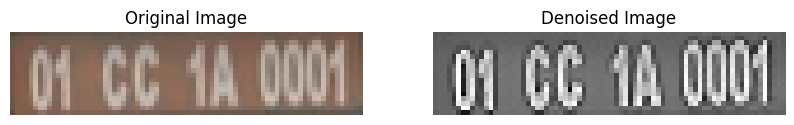

In [62]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(example, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Denoised Image")
plt.imshow(cv2.cvtColor(denoised, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

# **Binarization**

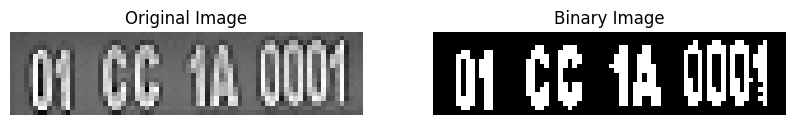

In [65]:
def binarization(image):
    img = denoised

    _, binary_img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

    return _, binary_img

_, binary_img = binarization(denoised)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Binary Image')
plt.imshow(binary_img, cmap='gray')
plt.axis('off')

plt.show()

# **Optical Character Recognition**

## **Teserract**

In [73]:
pytesseract.pytesseract.tesseract_cmd = r'/usr/local/lib/python3.10/dist-packages/pytesseract'
text = pytesseract.image_to_string(binary_img, lang='eng')
print(text)

PermissionError: [Errno 13] Permission denied: '/usr/local/lib/python3.10/dist-packages/pytesseract'

## **EasyOCR**

In [87]:
reader = easyocr.Reader(['en'])

def read_lisence(image):
    result = reader.readtext(image)

    for detection in result:
        text = detection[1]
        print(text)

In [89]:
read_lisence(denoised)

01 CC Ia 0001


In [90]:
read_lisence(binary_img)

0| Cc I4 O00A
